### Sparse Linear Operator
This is an example of how to create and tune a sparse linear operator.

In [1]:
import torch
import matplotlib.pyplot as plt
import sparta

First, we need to create a PyTorch dense linear operator. Suppose the input feature number is K, the output feature number is N and the batch size is M.

Note that the optimal implementation and configuration are different for different batch sizes, so we need to determine the batch size at the very early stage.

In [2]:
M, K, N = 4096, 3072, 768
dense_linear = torch.nn.Linear(K, N).cuda()

To build a linear operator with sparse weights, a weight mask tensor is required.

Let's generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

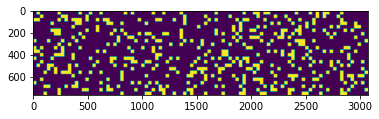

In [3]:
weight_mask = sparta.testing.block_mask((N, K), block=(32, 32), sparsity=0.8).cuda()
plt.imshow(weight_mask.cpu().numpy())

Create a ```sparta.nn.SparseLinear``` operator using the dense operator and the weight mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take half an hour.

In [4]:
x = torch.rand((M, K)).cuda()
sparse_linear = sparta.nn.SparseLinear(dense_linear, weight_mask=weight_mask)
sparta.nn.tune(sparse_linear, sample_inputs=[x])

[2022-09-11 03:05:43] Grid initialized, size: (2×3×3×3×2×2×2) = 432
==================== Tuning ====================
#0: {'b84d6f82': {'_name': 'sparta', 'BLOCK_SIZE_M_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 16, 'BLOCK_SIZE_K_VALUE': 16, 'THREAD_SIZE_M_VALUE': 4, 'THREAD_SIZE_N_VALUE': 4, 'THREAD_SIZE_K_VALUE': 4}}
Latency: 2.639965 ms
#1: {'b84d6f82': {'_name': 'sparta', 'BLOCK_SIZE_M_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 16, 'BLOCK_SIZE_K_VALUE': 16, 'THREAD_SIZE_M_VALUE': 4, 'THREAD_SIZE_N_VALUE': 4, 'THREAD_SIZE_K_VALUE': 8}}
Latency: 2.635331 ms
#2: {'b84d6f82': {'_name': 'sparta', 'BLOCK_SIZE_M_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 16, 'BLOCK_SIZE_K_VALUE': 16, 'THREAD_SIZE_M_VALUE': 4, 'THREAD_SIZE_N_VALUE': 8, 'THREAD_SIZE_K_VALUE': 4}}
Latency: 4.577847 ms
#3: {'b84d6f82': {'_name': 'sparta', 'BLOCK_SIZE_M_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 16, 'BLOCK_SIZE_K_VALUE': 16, 'THREAD_SIZE_M_VALUE': 4, 'THREAD_SIZE_N_VALUE': 8, 'THREAD_SIZE_K_VALUE': 8}}
Latency: 4.574039 ms
#4: {'b84d6f82': {'_nam

Let's check whether the sparse operator works correctly.

In [5]:
sparse_weight = dense_linear.weight * weight_mask
dense_linear.load_state_dict(dict(weight=sparse_weight, bias=dense_linear.bias))
torch.testing.assert_close(sparse_linear(x), dense_linear(x))

AssertionError: Tensor-likes are not close!

Mismatched elements: 3145573 / 3145728 (100.0%)
Greatest absolute difference: 0.9778047502040863 at index (998, 355) (up to 1e-05 allowed)
Greatest relative difference: 464860.49809885933 at index (2670, 258) (up to 1.3e-06 allowed)


Finally, take a look at how much time can be saved by using the sparse linear operator!

In [ ]:
dense_latency = sparta.testing.test_latency(dense_linear, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_linear, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')

Dense linear operator latency: 2.8643740234375 ms
Sparse linear operator latency: 1.49138427734375 ms
